In [1]:
import torch
from IPython import display
from d2l import torch as d2l
import numpy as np
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [2]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [3]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [4]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1294, 0.2819, 0.3133, 0.0264, 0.2489],
         [0.1146, 0.5104, 0.0866, 0.0523, 0.2361]]),
 tensor([1.0000, 1.0000]))

In [5]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [6]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [7]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [8]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [9]:
accuracy(y_hat, y) / len(y)

0.5

In [10]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [11]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [12]:
evaluate_accuracy(net, test_iter)

0.0604

In [13]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [14]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [24]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [25]:
lr = 0.2

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

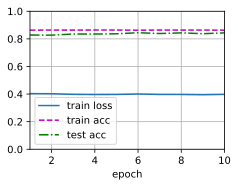

In [26]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [49]:
def predict_ch3(net, test_iter, n=100):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

模型权重 (W):
tensor([[-0.0043, -0.0014, -0.0138,  ...,  0.0050, -0.0086,  0.0068],
        [ 0.0222,  0.0115, -0.0072,  ..., -0.0027, -0.0105, -0.0093],
        [ 0.0274, -0.0066, -0.0020,  ..., -0.0019, -0.0139, -0.0026],
        ...,
        [-0.0900, -0.0304,  0.3126,  ..., -0.0124, -0.1588,  0.0237],
        [-0.0568,  0.0092,  0.0678,  ...,  0.0119, -0.1014,  0.0352],
        [-0.0100,  0.0073,  0.0206,  ..., -0.0090, -0.0292,  0.0308]],
       requires_grad=True)

模型偏置 (b):
tensor([ 0.9395, -1.3483, -0.1349,  0.8968, -2.6681,  3.6213,  0.7519,  0.5934,
        -0.4812, -2.1705], requires_grad=True)


  0%|          | 0/500 [00:00<?, ?it/s]

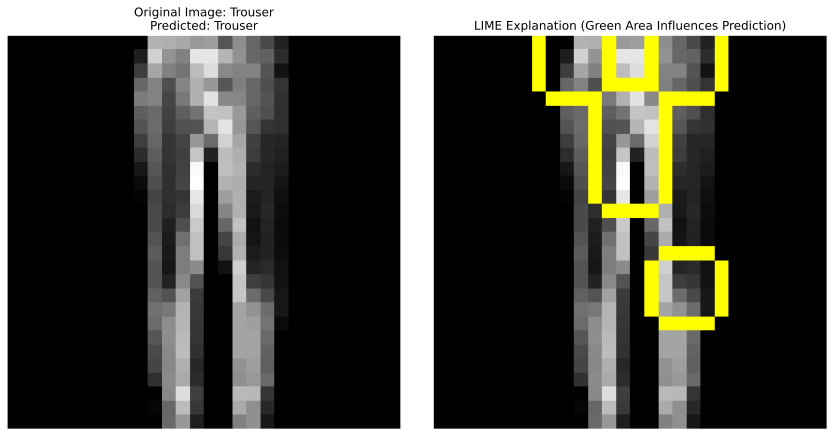

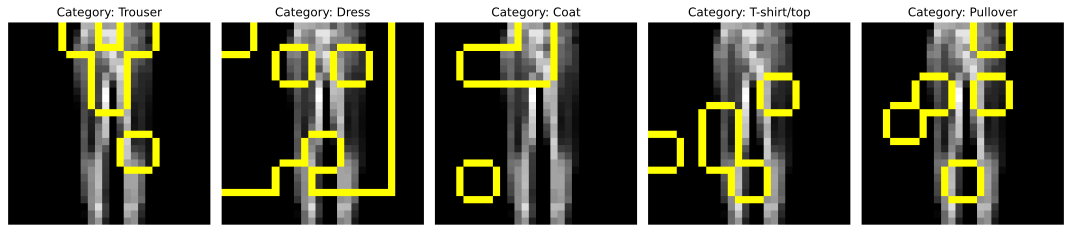

预测类别 'Trouser' 的特征重要性:
特征 9: 0.3592
特征 4: 0.1792
特征 15: 0.1602
特征 2: 0.1434
特征 28: 0.1139
特征 22: 0.1064
特征 0: 0.0891
特征 34: 0.0749
特征 21: 0.0747
特征 16: 0.0516


In [68]:
# LIME 解释模型预测
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import numpy as np

# 定义预测函数
def predict_fn(images):
    # 将图像转换为适合模型的格式
    batch_size = images.shape[0]
    # 对于灰度图像，确保形状正确
    if len(images.shape) == 4 and images.shape[3] == 3:
        # 如果是 RGB 格式，转换为灰度
        images_gray = np.mean(images, axis=3)
        images_reshaped = images_gray.reshape(batch_size, -1).astype('float32')
    else:
        # 已经是灰度图像
        images_reshaped = images.reshape(batch_size, -1).astype('float32') 
    
    # 使用您的模型进行预测
    with torch.no_grad():
        images_tensor = torch.tensor(images_reshaped)
        probs = net(images_tensor).numpy()
    
    return probs

# 创建解释器
explainer = lime_image.LimeImageExplainer()

# 定义分割算法
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

# 从测试集获取一个样本
for X, y in test_iter:
    break

# 选择一个样本
idx = 65 # 可以尝试不同的索引
image = X[idx].numpy().transpose(1, 2, 0)  # 转换为 (H, W, C) 格式
image = image.squeeze()  # 移除通道维度，因为 Fashion-MNIST 是灰度图像
label = y[idx].item()

# 获取标签名称
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
true_label = label_names[label]

# 生成解释
# explanation = explainer.explain_instance(
#     image, 
#     predict_fn, 
#     top_labels=5, 
#     hide_color=0, 
#     num_samples=5000,
#     segmentation_fn=segmenter
# )
def grid_segments(image, grid_size=16):
    """创建简单的网格分割"""
    segments = np.zeros(image.shape[:2], dtype=np.int32)
    h, w = image.shape[:2]
    h_step, w_step = h // grid_size, w // grid_size
    for i in range(grid_size):
        for j in range(grid_size):
            segments[i*h_step:(i+1)*h_step, j*w_step:(j+1)*w_step] = i * grid_size + j
    return segments

# 使用 4x4 网格，共 16 个超像素
explanation = explainer.explain_instance(
    image, 
    predict_fn, 
    top_labels=5, 
    hide_color=0, 
    num_samples=500,
    batch_size=50,
    segmentation_fn=lambda x: grid_segments(x, grid_size=6)
)
# 获取预测标签
pred = predict_fn(np.expand_dims(image, axis=0))[0]
pred_idx = np.argmax(pred)
pred_label = label_names[pred_idx]

# 显示原始图像和解释
plt.figure(figsize=(12, 6))

# 原始图像
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f'Original Image: {true_label}\nPredicted: {pred_label}')
plt.axis('off')

# LIME 解释
temp, mask = explanation.get_image_and_mask(
    pred_idx, 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask), cmap='gray')
plt.title('LIME Explanation (Green Area Influences Prediction)')
plt.axis('off')

plt.tight_layout()
plt.show()

# 显示不同标签的解释
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, label_id in enumerate(explanation.top_labels[:5]):
    temp, mask = explanation.get_image_and_mask(
        label_id, 
        positive_only=True, 
        num_features=5, 
        hide_rest=False
    )
    axes[i].imshow(mark_boundaries(temp, mask), cmap='gray')
    axes[i].set_title(f'Category: {label_names[label_id]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 打印特征重要性
print(f"预测类别 '{pred_label}' 的特征重要性:")
for feature, importance in explanation.local_exp[pred_idx][:10]:
    print(f"特征 {feature}: {importance:.4f}")